<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Lambda, Activation, Reshape,\
Softmax, Multiply, AdditiveAttention, Concatenate, Add, RepeatVector
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import to_categorical

from math import log
from numpy import array, argmax
import sklearn

import pprint

In [2]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="CS6910-assg3", entity="narendv")

wandb: Currently logged in as: narendv (use `wandb login --relogin` to force relogin)


wandb: Currently logged in as: narendv (use `wandb login --relogin` to force relogin)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Examples

File extraction

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [ ]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

# Loading datasets

In [4]:
def load_data(data_path, data):
  input_texts=[]
  target_texts = []
  global tk_input, tk_target, num_input_tokens, num_target_tokens
  
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
  random.seed(10)
  random.shuffle(input_texts)
  random.seed(10)
  random.shuffle(target_texts)
     
  if (data == "train"):
    tk_input = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_input.fit_on_texts(input_texts)
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post')

    tk_target = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_target.fit_on_texts(target_texts)
    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post')

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  else:
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post', maxlen = max_input_length)

    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post', maxlen = max_target_length)

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  return enc_input, dec_target, dec_input

In [5]:
# Number of samples to train on.
# Path to the data txt file on disk.
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'

In [6]:
global enc_input_train, dec_input_train, dec_target_train, enc_input_dev, dec_input_dev, dec_target_dev
global tk_input, tk_target
global input_token_train, output_token_train, max_input_length, max_target_length
global y_true_dev, y_true_train

batch_size = 256

enc_input_train, dec_input_train, dec_target_train = load_data(data_path_train,'train')

max_input_length = enc_input_train.shape[1]
max_target_length = dec_target_train.shape[1]

num_input_tokens = len(tk_input.word_index)+1
num_target_tokens = len(tk_target.word_index)+1

enc_input_dev, dec_input_dev, dec_target_dev = load_data(data_path_dev,'dev')

One hot encoding of the target outputs

In [7]:
y_true_dev = np.zeros((dec_target_dev.shape[0],dec_target_dev.shape[1], num_target_tokens))
for i in range(0,dec_target_dev.shape[0]):
  y_true_dev[i] = to_categorical(dec_target_dev[i], num_classes = num_target_tokens)

y_true_train = np.zeros((dec_target_train.shape[0],dec_target_train.shape[1], num_target_tokens))
for i in range(0,dec_target_train.shape[0]):
  y_true_train[i] = to_categorical(dec_target_train[i], num_classes = num_target_tokens)

# Defining functions

Encoder

In [8]:
def encoder(enc_out,enc_block, latent_dim, enc_layers):
  states = []
  for i in range(0,enc_layers):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      s = [h,c]
      states.append(s)
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    
  return enc_out,states

Decoder

In [9]:
def decoder(X_input_dec, hs_init, latent_dim, dec_block, dec_layers, dense_no, drop_no):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    elif dec_block == 'GRU':
      out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    else:
      out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  
  if dense_no != 0:
    out_dec = TimeDistributed(Dense(dense_no, activation="relu", name = 'output'), name = 'dense_hidden')(out_dec)
    out_dec = Dropout(drop_no)(out_dec)
  out_dec = TimeDistributed(Dense(num_target_tokens, activation="softmax", name = 'output'), name = 'dense')(out_dec)
  
  return out_dec

Bahnadau Attention

In [10]:
def b_attention(latent_dim):

  query_in = keras.Input((latent_dim,))
  values_in = keras.Input((max_input_length,latent_dim))
  query = Reshape((1,latent_dim), name='query_reshape')(query_in)
  score_unit2 = Dense(num_target_tokens, name='score_unitq')(query)
  score_unit1 = Dense(num_target_tokens, name='score_unitv')(values_in)
  score_unit12 = Add()([score_unit1, score_unit2])
  score_unit12 = Activation('tanh')(score_unit12)
  score = Dense(1)(score_unit12)
  attention_weights = Softmax(axis=1)(score)
  context_vector = Multiply()([attention_weights,values_in])
  context_vector = Lambda(lambda x: tf.reduce_sum(x,axis=1))(context_vector)
  context_vector = RepeatVector(max_target_length)(context_vector)

  model = Model(inputs = [query_in,values_in], outputs = [context_vector, attention_weights], name='attention')
  return model

In [ ]:
att_model = b_attention(256)
keras.utils.plot_model(att_model,show_shapes=True, rankdir='TB')

Final RNN model for training

In [12]:
def RNN_model(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))
  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)
  _,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')
  return model

Final RNN model with attention for training

In [13]:
def RNN_w_att(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))

  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)

  values,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  context_vector, weights = b_attention(latent_dim)([s_init[len(s_init)-1][0], values])
  X_dec = Concatenate(name = 'concatenate')([context_vector,X_dec])

  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')

  return model

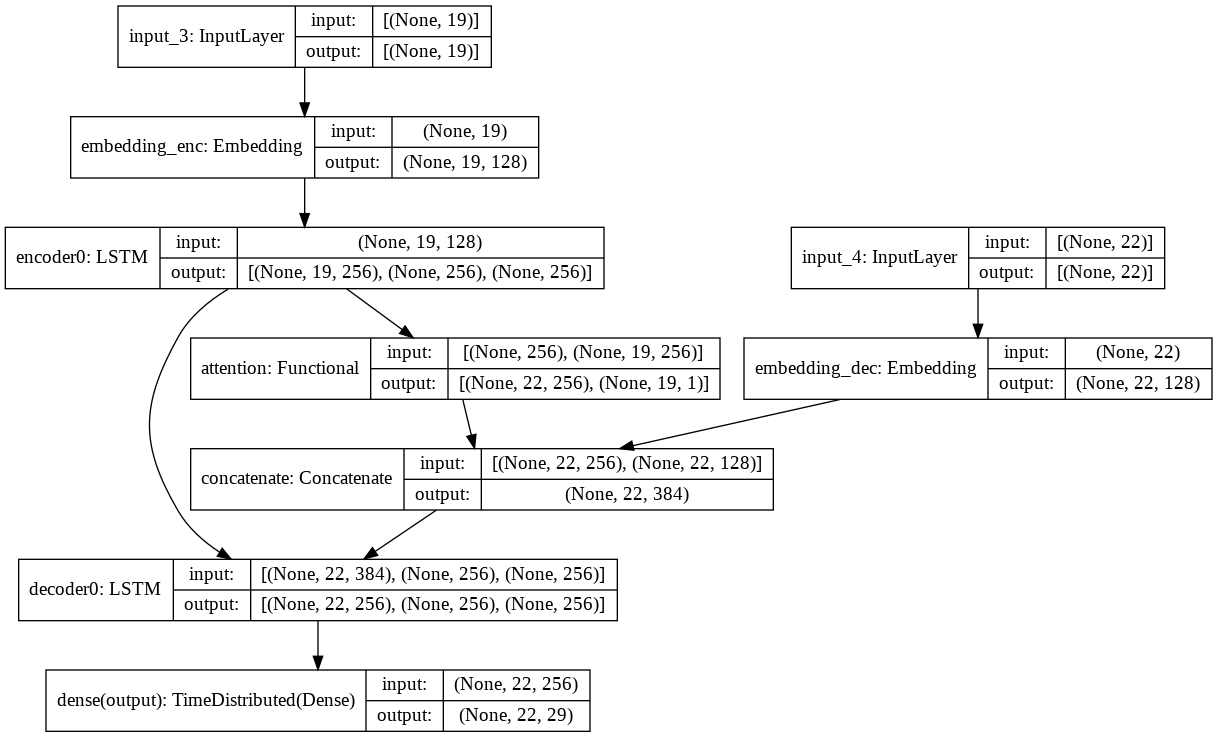

In [31]:
rnnmodel= RNN_w_att(128,'LSTM',256,'LSTM',0,0,1,1)
keras.utils.plot_model(rnnmodel,show_shapes=True, rankdir='TB')

Inference Encoder and Decoder

In [14]:
def enc_inference(model,enc_layers):
  X_enc = model.input[0]
  X_in_enc = model.get_layer('embedding_enc')(X_enc)
  enc_outputs = X_in_enc
  states = []
  for i in range(0,enc_layers):
    enc_outputs, h_enc, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
    states.append([h_enc, s_enc])
  enc_model = keras.Model(inputs = X_enc, outputs = states)
  return enc_model

def dec_inference(model, latent_dim, dec_layers):
  dec_inputs = model.input[1]
  dec_outputs = model.get_layer('embedding_dec')(dec_inputs)
  hs_inputs = []
  for i in range(0,dec_layers):
    h = keras.Input(shape=(latent_dim,))
    c = keras.Input(shape=(latent_dim,))
    hs_inputs.append([h,c])
  hs_outputs = []
  for i in range(0,dec_layers):
    dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
    hs_outputs.append([h_dec,s_dec])
  dec_dense = model.get_layer('dense')
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs] + hs_inputs, outputs = [dec_outputs] + hs_outputs)  
  return dec_model

Greedy decoder function

In [15]:
def greedy_decoder(enc_inf, dec_inf, input_seq):
  states = enc_inf.predict(input_seq)
  target_seq = np.zeros((input_seq.shape[0],1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[tk_target.word_index["\t"]] for _ in range (input_seq.shape[0])]
  for i in range(max_target_length):
    output_tokens, h, c = dec_inf.predict([target_seq] + states)
    x = np.argmax(output_tokens, axis=-1)
    target_seq = x
    for j in range(input_seq.shape[0]):
      pred[j].append(target_seq[j][0])
    states = [h,c]
  return pred

Beam Search Function and Decoder

In [16]:
def beam_search(enc_inf, dec_inf, input_seq, k):
  states = enc_inf.predict(input_seq)
  target_seq = np.zeros((3,1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[[tk_target.word_index["\t"]], 0.0] for _ in range (3)]

  for i in range(max_target_length):
    all_candidates = list()
    output_tokens, h, c = dec_inf.predict([target_seq] + states)
    states = [h,c]
    for j in range(len(pred)):
      seq, score = pred[j]
      for l in range(output_tokens.shape[-1]):
        candidate = [seq + [l], score - log(output_tokens[j][0][l])]
        all_candidates.append(candidate)
      if i==0:
        break
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    pred = ordered[:3]
    for j in range (3):
      target_seq[j] = pred[j][0][i+1]

  final_pred = ordered[:1]
  return (final_pred[0][0])

In [17]:
def beam_search_decoder(enc_inf, dec_inf, input_seq, k):
  pred = []
  for i in range(input_seq.shape[0]):
    input = input_seq[i:i+1,:]
    input = np.concatenate((input,)*k, axis = 0)
    pred.append(beam_search(enc_inf, dec_inf, input, k))
    if i%100 == 0:
      print((i/input_seq.shape[0])*100)
  return pred

Integer encoding to character mapping

In [18]:
reverse_input_char_index = dict((i, char) for char, i in tk_input.word_index.items())
reverse_target_char_index = dict((i, char) for char, i in tk_target.word_index.items())

Encoding to Word conversion

In [19]:
def transliteration(inputs):
  start = tk_target.word_index["\t"]
  end = 0
  words = []
  for i in range(len(inputs)):
    start_index = inputs[i].index(start)
    end_index = inputs[i].index(end)
    temp = inputs[i][start_index+1:end_index]
    word = (list(map(reverse_target_char_index.__getitem__, temp)))
    if (word[-1]=="\n"):
      # print ("yayyy")
      word.pop(-1)
    separator = ''
    word_new = separator.join(word)
    words.append(word_new)
  return words

Word Accuracy Metric

In [21]:
def word_accuracy(true_words, pred_words):
  count = len([i for i, j in zip(true_words, pred_words) if i==j])
  return count/len(pred_words)

# Rest of the code

In [ ]:
model = RNN_model(256, 'LSTM', 512, 'LSTM', 256, 0, 2, 2)
keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [ ]:
model.compile(optimizer=Adam(1e-2), loss = 'categorical_crossentropy', metrics=['accuracy'])#, word_accuracy])
model.fit([enc_input_train,dec_input_train], y_true_train, 
          batch_size = 128,epochs=10, validation_data=([enc_input_dev,dec_input_dev], y_true_dev))

In [25]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'embedding_no':{
        'values': [128]
      },
    'rnn_block':{
        'values': ['RNN','GRU','LSTM']
      },
    'no_of_layers': {
        'values': [1]
      },
    'latent_dimension': {
        'values': [256]
      },
    'hidden_layer': {
        'values': [0]
      },
    'dropout': {
        'values': [0]
      },
    'beam_search': {
        'values': [False]
      },
    'epochs' : {
        'values' : [20]
      },
    'optimizer' : {
        'values' : ['adam']
      },
    'learning_rate' : {
        'values' : [1e-2]
      },
    'attention' : {
        'values' : [False]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        if config.attention == True:
          model = RNN_w_att(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        else:
          model = RNN_model(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        
        if config.optimizer == 'adam':
          config.optimizer = Adam(config.learning_rate)
        else:
          config.optimizer = RMSprop(config.learning_rate)
        model.compile(optimizer = config.optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

        model.fit([enc_input_train,dec_input_train], y_true_train, 
                            epochs=config.epochs,
                            validation_data = ([enc_input_dev,dec_input_dev], y_true_dev),
                            callbacks = [WandbCallback()]
                            )

        name = str(config.rnn_block) + '_' + str(config.no_of_layers) + '_' + str(config.embedding_no) + '_' + str(config.latent_dim) + '_' + str(config.hidden_layer) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/Transliteration/' + name
        model.save(location)

        enc_inf = enc_inference(model, config.no_of_layers)
        dec_inf = dec_inference(model, config.latent_dimension, config.no_of_layers)

        if config.beam_search:
          predictions = beam_search_decoder(enc_inf, dec_inf, enc_input_dev, k)
        else:
          predictions = greedy_decoder(enc_inf, dec_inf, enc_input_dev)

          # word_acc = word_accuracy(dec_target_dev,np.array(predictions))
          # word_acc = sklearn.metrics.accuracy_score(dec_target_dev,np.array(predictions))
          pred_words = transliteration(predictions)

          true = list(list(dec_input_dev[i]) for i in range(dec_input_dev.shape[0]))
          true_words = transliteration(list(true))
          word_acc = word_accuracy(true_words, pred_words)
          wandb.log({'word_level_accuracy': word_acc})

{'method': 'grid',
 'parameters': {'attention': {'values': [False]},
                'beam_search': {'values': [False]},
                'dropout': {'values': [0]},
                'embedding_no': {'values': [128]},
                'epochs': {'values': [20]},
                'hidden_layer': {'values': [0]},
                'latent_dimension': {'values': [256]},
                'learning_rate': {'values': [0.01]},
                'no_of_layers': {'values': [1]},
                'optimizer': {'values': ['adam']},
                'rnn_block': {'values': ['RNN', 'GRU', 'LSTM']}}}


In [26]:
sweep_id = wandb.sweep(sweep_config, project="CS6910-assg3")
wandb.agent(sweep_id, training_sweep)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: evo3qemj
Sweep URL: https://wandb.ai/narendv/CS6910-assg3/sweeps/evo3qemj


wandb: Agent Starting Run: w4dget1c with config:
wandb: 	attention: False
wandb: 	beam_search: False
wandb: 	dropout: 0
wandb: 	embedding_no: 128
wandb: 	epochs: 20
wandb: 	hidden_layer: 0
wandb: 	latent_dimension: 256
wandb: 	learning_rate: 0.01
wandb: 	no_of_layers: 1
wandb: 	optimizer: adam
wandb: 	rnn_block: RNN


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).


Epoch 1/20
1382/1382 [==============================] - 66s 46ms/step - loss: 0.9158 - accuracy: 0.7433 - val_loss: 0.6463 - val_accuracy: 0.8067
Epoch 2/20
1382/1382 [==============================] - 63s 46ms/step - loss: 0.6505 - accuracy: 0.8058 - val_loss: 0.5932 - val_accuracy: 0.8238
Epoch 3/20
1382/1382 [==============================] - 63s 46ms/step - loss: 0.6018 - accuracy: 0.8189 - val_loss: 0.5800 - val_accuracy: 0.8246
Epoch 4/20
1382/1382 [==============================] - 63s 46ms/step - loss: 0.5756 - accuracy: 0.8253 - val_loss: 0.5560 - val_accuracy: 0.8331
Epoch 5/20
1382/1382 [==============================] - 64s 46ms/step - loss: 0.5510 - accuracy: 0.8325 - val_loss: 0.5507 - val_accuracy: 0.8360
Epoch 6/20
1382/1382 [==============================] - 63s 46ms/step - loss: 0.5345 - accuracy: 0.8367 - val_loss: 0.5400 - val_accuracy: 0.8366
Epoch 7/20
1382/1382 [==============================] - 63s 46ms/step - loss: 0.5184 - accuracy: 0.8414 - val_loss: 0.5307 -

epoch,19
loss,0.46039
accuracy,0.85663
val_loss,0.52618
val_accuracy,0.84243
_runtime,1275
_timestamp,1621536418
_step,19
best_val_loss,0.51464
best_epoch,10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
accuracy,▁▄▅▅▆▆▇▇▇▇▇█████████
val_loss,█▅▄▃▃▂▂▂▁▂▁▂▂▁▂▂▁▂▁▂
val_accuracy,▁▄▄▆▆▇▇▇█▇██▇█▇█████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: ERROR Run w4dget1c errored: KeyError('encoder_block')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x352fb7f with config:
wandb: 	attention: False
wandb: 	beam_search: False
wandb: 	dropout: 0
wandb: 	embedding_no: 128
wandb: 	epochs: 20
wandb: 	hidden_layer: 0
wandb: 	latent_dimension: 256
wandb: 	learning_rate: 0.01
wandb: 	no_of_layers: 1
wandb: 	optimizer: adam
wandb: 	rnn_block: GRU


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).


Epoch 1/20
1382/1382 [==============================] - 36s 23ms/step - loss: 1.0173 - accuracy: 0.7253 - val_loss: 0.7072 - val_accuracy: 0.7822
Epoch 2/20
1382/1382 [==============================] - 31s 22ms/step - loss: 0.6580 - accuracy: 0.7973 - val_loss: 0.4393 - val_accuracy: 0.8640
Epoch 3/20
1382/1382 [==============================] - 31s 22ms/step - loss: 0.3935 - accuracy: 0.8789 - val_loss: 0.2589 - val_accuracy: 0.9229
Epoch 4/20
1382/1382 [==============================] - 30s 22ms/step - loss: 0.2424 - accuracy: 0.9268 - val_loss: 0.2003 - val_accuracy: 0.9398
Epoch 5/20
1382/1382 [==============================] - 31s 22ms/step - loss: 0.1863 - accuracy: 0.9430 - val_loss: 0.1894 - val_accuracy: 0.9427
Epoch 6/20
1382/1382 [==============================] - 31s 22ms/step - loss: 0.1615 - accuracy: 0.9489 - val_loss: 0.1713 - val_accuracy: 0.9478
Epoch 7/20
1382/1382 [==============================] - 31s 22ms/step - loss: 0.1431 - accuracy: 0.9543 - val_loss: 0.1601 -

epoch,19
loss,0.0837
accuracy,0.96754
val_loss,0.16013
val_accuracy,0.95136
_runtime,621
_timestamp,1621537055
_step,19
best_val_loss,0.15405
best_epoch,11


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▆▇▇▇██████████████
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▇▇████████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: ERROR Run x352fb7f errored: KeyError('encoder_block')
wandb: Agent Starting Run: whri4xoj with config:
wandb: 	attention: False
wandb: 	beam_search: False
wandb: 	dropout: 0
wandb: 	embedding_no: 128
wandb: 	epochs: 20
wandb: 	hidden_layer: 0
wandb: 	latent_dimension: 256
wandb: 	learning_rate: 0.01
wandb: 	no_of_layers: 1
wandb: 	optimizer: adam
wandb: 	rnn_block: LSTM


wandb: WARNING Config item 'optimizer' was locked by 'sweep' (ignored update).


Epoch 1/20
1382/1382 [==============================] - 40s 27ms/step - loss: 0.9822 - accuracy: 0.7327 - val_loss: 0.6746 - val_accuracy: 0.7929
Epoch 2/20
1382/1382 [==============================] - 35s 25ms/step - loss: 0.6221 - accuracy: 0.8063 - val_loss: 0.4330 - val_accuracy: 0.8641
Epoch 3/20
1382/1382 [==============================] - 35s 25ms/step - loss: 0.3963 - accuracy: 0.8760 - val_loss: 0.2758 - val_accuracy: 0.9168
Epoch 4/20
1382/1382 [==============================] - 34s 25ms/step - loss: 0.2501 - accuracy: 0.9235 - val_loss: 0.2090 - val_accuracy: 0.9363
Epoch 5/20
1382/1382 [==============================] - 34s 25ms/step - loss: 0.1880 - accuracy: 0.9417 - val_loss: 0.1808 - val_accuracy: 0.9439
Epoch 6/20
1382/1382 [==============================] - 34s 24ms/step - loss: 0.1576 - accuracy: 0.9501 - val_loss: 0.1647 - val_accuracy: 0.9480
Epoch 7/20
1382/1382 [==============================] - 34s 24ms/step - loss: 0.1384 - accuracy: 0.9552 - val_loss: 0.1530 -

epoch,19
loss,0.07314
accuracy,0.97002
val_loss,0.14907
val_accuracy,0.95558
_runtime,689
_timestamp,1621537753
_step,19
best_val_loss,0.14142
best_epoch,12


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▅▇▇▇▇█████████████
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▄▆▇▇███████████████
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██


wandb: ERROR Run whri4xoj errored: KeyError('encoder_block')
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.
